In [1]:
from langgraph.graph import StateGraph,START ,END
from typing import TypedDict,Optional,Literal
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from dotenv import load_dotenv
load_dotenv()

c:\Users\samar\anaconda3\envs\agent_env\Lib\site-packages\langchain_core\_api\deprecation.py:25: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


True

In [2]:
model = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)

In [33]:
class SentimentState(BaseModel):
    sentiment : Literal['positive','negative'] = Field( description="The sentiment of the review, can be either 'positive' or 'negative'")

In [34]:
struc_model=model.with_structured_output(SentimentState)

In [35]:
class DiagnoseState(BaseModel):
    issue_type : Literal['UX','Performance','Bug','Support','Other'] = Field( description="The category of issue mentioned in the review")
    tone : Literal['angry','frustrated','disappointed','calm'] = Field( description="The emotional tone expressed by the users")
    urgency : Literal['high','medium','low'] = Field( description="The urgency level of the reply")

In [36]:
struc_diagnose_model=model.with_structured_output(DiagnoseState)

In [37]:
prompt = 'What is the sentiment of the review: "The product is great, I really like it!"?'
struc_model.invoke(prompt)

SentimentState(sentiment='positive')

In [39]:
class ReviewState(TypedDict):
    review :str 
    sentiment : Literal['positive','negative']
    diagnose : dict
    response :str

In [40]:
def find_sentiment(state:ReviewState):
    prompt = f'What is the sentiment of the review: "{state["review"]}"?'
    result = struc_model.invoke(prompt)
    return {'sentiment': result.sentiment}

In [41]:
def check_sentiment(state:ReviewState)->Literal['positive_response','run_diagnose']:
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else :
        return 'run_diagnose'

In [42]:
def positive_response(state:ReviewState):
    prompt = f"""Write a warm and friendly reply to the positive review: "{state['review']}" \n
            Also kindly ask the users to leave a 5-star rating."""
    response = model.invoke(prompt)
    return {'response': response}

In [43]:
def run_diagnose(state:ReviewState):
    prompt = f"""Diagnose the negative review:\n\n{state['review']}\n\nReturn issue_type, tone and urgency."""
    result = struc_diagnose_model.invoke(prompt)
    return {'diagnose': result.model_dump()}

In [47]:
def negative_response(state:ReviewState):
    prompt = f"""Write a empathetic and helpful reply to the negative review: "{state['review']}" 
            Address the issue type: {state['diagnose']['issue_type']}, 
            Acknowledge the user's tone: {state['diagnose']['tone']}, 
            and respond according to the urgency level: {state['diagnose']['urgency']}."""
    response = model.invoke(prompt)
    return {'response': response}

In [48]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment',find_sentiment)
graph.add_node('positive_response',positive_response)
graph.add_node('run_diagnose',run_diagnose)
graph.add_node('negative_response',negative_response)


graph.add_edge(START,'find_sentiment')
graph.add_conditional_edges('find_sentiment',check_sentiment)
graph.add_edge('positive_response',END)
graph.add_edge('run_diagnose','negative_response')
graph.add_edge('negative_response',END)

workflow = graph.compile()

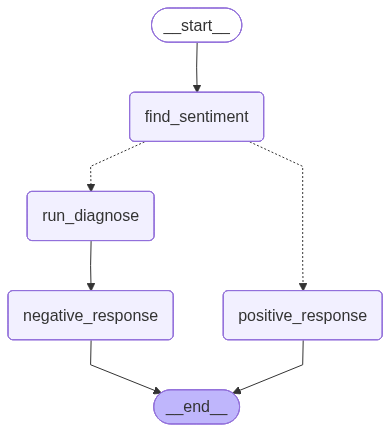

In [31]:
workflow

In [46]:
intital_state = {'review': "the app crashes frequently and the support team is unresponsive."}
workflow.invoke(intital_state)

{'review': 'the app crashes frequently and the support team is unresponsive.',
 'sentiment': 'negative',
 'diagnose': {'issue_type': 'Bug', 'tone': 'angry', 'urgency': 'high'},
 'response': AIMessage(content='"I\'m so sorry to hear that you\'re experiencing frequent crashes with our app, and that our support team hasn\'t been responsive to your concerns. I can imagine how frustrating that must be for you, and I apologize for the inconvenience and anger that\'s caused.\n\nI want to assure you that we take issues like this very seriously, and I\'m going to escalate your problem to our development team immediately. We\'ll do our best to identify the cause of the crashes and push out a fix as soon as possible.\n\nIn the meantime, I\'d like to offer you a direct line of contact with our support team, so you can get the help you need right away. Please DM us with your contact information, and we\'ll have someone reach out to you within the next 24 hours to troubleshoot the issue and provide 

In [49]:
intital_state = {'review': "Like the product the features are very useful and easy to use."}
workflow.invoke(intital_state)

{'review': 'Like the product the features are very useful and easy to use.',
 'sentiment': 'positive',
 'response': AIMessage(content="Dear valued customer,\n\nA huge thank you from our team for taking the time to share your wonderful feedback about our product! We're thrilled to hear that you're enjoying the features and finding them easy to use - that's exactly what we're aiming for!\n\nWe're so glad you're getting the most out of our product, and we appreciate your kind words. Your satisfaction means the world to us, and we're grateful for customers like you who make our efforts worthwhile.\n\nAs a small favor, could you please consider leaving a 5-star rating to help spread the word about your positive experience? Your review will not only help others discover our product but also encourage us to keep innovating and improving.\n\nOnce again, thank you for your lovely review, and we look forward to continuing to serve you with the best possible experience!\n\nBest regards, [Your Nam